<a href="https://colab.research.google.com/github/lutherkhill/codemash2020/blob/master/codemash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Civic Developers Quest to Change Healthcare**


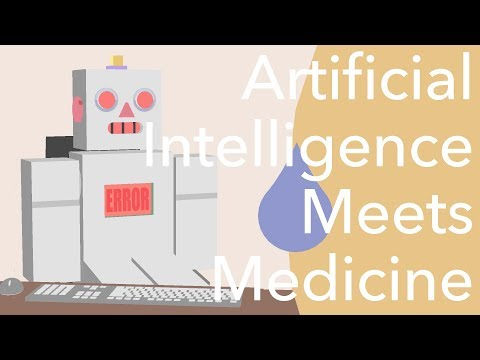

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('ZIiYbMVs7-8')

##Description and problem statement

For this application we used PyTorch and FastAi libary to design our model. We got our data from Kaggle using the Chest X-ray datset from the National Insitutue of Health (NIH). We used Jupyter notebooks that was hosted in the cloud using Google Colab to build and deploy our model. the Google Colab infrastructure allows us to leverage free resources like Graphical Processing Units (GPU) and SSD hard drives. 

To train our 

##Goals for talk

We will build and deploy a model tht meets the current state of the art for chest x-ray disease prediction using the AUC-ROC socring metric.

# **The dataset**

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# load fastai dependencies
import fastai
from fastai.vision import *
from fastai.metrics import *

# Imports for diverse utilities
import torchvision.models as models
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern
from sklearn.metrics import roc_auc_score, recall_score

#conect to google drive to easier storeage and redundency
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
from IPython.display import IFrame
IFrame('https://blog.revolutionanalytics.com/2016/11/calculating-auc.html',
       width='100%', height=500)

## Get the data
The NIH dataset is freely availble on kaggle. For this exercise we will be using a smaple set o the data. Let's see how to do this by using the Kaggle API as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add source activate fastai or similar, or prefix pip with a path. Have a look at how conda install is called for your platform in the appropriate Returning to work section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
# install the kaggle command line tool
# ! {sys.executable} -m pip install kaggle --upgrade

You're all set to download the data from planet competition. You first need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a 403 forbidden error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on Rules tab, and then scroll to the bottom to find the accept button).

In [0]:
# this will download the dataset right into your gdrive and unzip the file
# !kaggle datasets download -d nih-chest-xrays/sample
# !unzip -q sample.zip

## Preprocess the data for learning



### Load data

In [0]:
# set path to data
path = "/gdrive/My Drive/heart_disease/sample/images"

# set path for data labels
df_label_nih = pd.read_csv(path+'/label_nih.csv')

In [0]:
# we are going to take a look at the first 5 and the last 5 rows
df_label_nih.head()

,image,labels
0,00000030_001.png,Lung_anomalies
1,00000175_001.png,Lung_anomalies
2,00000175_002.png,Lung_anomalies
3,00000642_000.png,Lung_anomalies
4,00000816_000.png,Lung_anomalies


1. Delte the following labels

- delete hernia- not cinically relevant

- delete pneumothorax- not clinically relevant becaue case already had tubes and were treated

- delete Pneumonia, emphysema, and most of fibrosis : these are diagnosed clnically not based on imaging

2. create the folowwing classes

- Fluid in lungs
consolidation / infiltration / atelectasis / pneumonia/ effusion/ Pleural_Thickening

- Heart disease 
Cardiomegaly

- Lung mass
mass/ nodule





In [0]:
#number of images
img_files = os.listdir(path)
img_files[:5], len(img_files)

(['00022931_000.png',
  '00023203_002.png',
  '00023154_000.png',
  '00023160_006.png',
  '00023156_019.png'],
 5615)

In [0]:
df_label_nih.describe()

,image,labels
count,2331,2331
unique,2331,21
top,00020190_002.png,Lung_anomalies
freq,1,1544


In [0]:
# construct the the data source
#convert to black and white
#convert_mode='L'
np.random.seed(42)
src = (ImageList.from_csv(path, 'label_nih.csv').split_by_rand_pct(0.2).label_from_df(label_delim='|', cols='labels'))

In [0]:
# sets the transformation for the dat to crop out unused parts of the image
tfms = get_transforms(do_flip=True, 
                      max_zoom=1.03,
                      )

In [0]:
#construct data bunch (need to add weight decay and drop out rate to improve accuracy)
data = (src.transform(size=512,)
        .databunch(bs=18).normalize(imagenet_stats))

In [0]:
# list the names of you data classes
data.classes

['Cardiomegaly', 'Edema', 'Lung_anomalies', 'Mass']

In [0]:
# data bunch information
data

ImageDataBunch;

Train: LabelList (1865 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
Lung_anomalies,Lung_anomalies,Lung_anomalies,Lung_anomalies,Lung_anomalies
Path: /gdrive/My Drive/heart_disease/sample/images;

Valid: LabelList (466 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
Cardiomegaly,Lung_anomalies,Lung_anomalies,Lung_anomalies,Lung_anomalies
Path: /gdrive/My Drive/heart_disease/sample/images;

Test: None

In [0]:
# show the number of classes that your data has
data.c

4

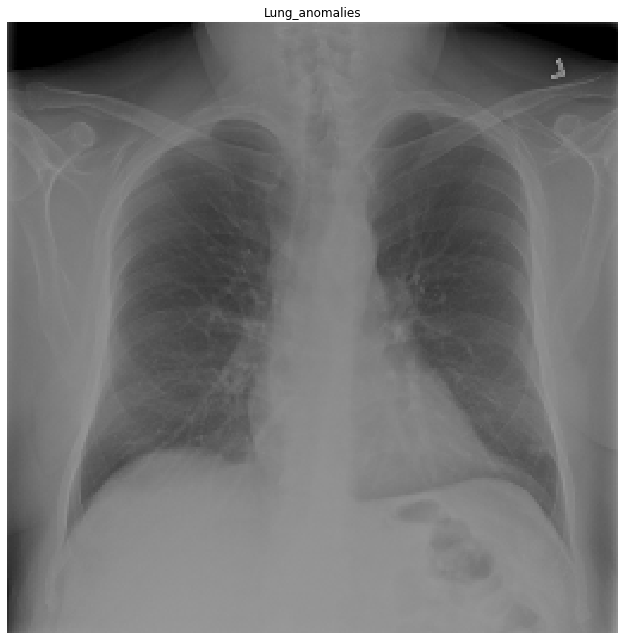

In [0]:
#display data bunch
# size/quality of the image matters greatly from medical imaging analysis
data.show_batch(rows=1, figsize=(12,9))

#**The model**
Our base architecture is `resnet50` again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of accuracy. We determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

> Indented block



### Single Model

In [0]:
# create convolutional neural network and return the accuracy metric
ResNet = cnn_learner(data, models.wide_resnet101_2, metrics=[fbeta]).to_fp16()
#GoogleNet = cnn_learner(data, models.googlenet, metrics=[AUROC(), fbeta]).to_fp16()

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth
100%|██████████| 243M/243M [00:04<00:00, 53.1MB/s]


In [0]:
WideResNet.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


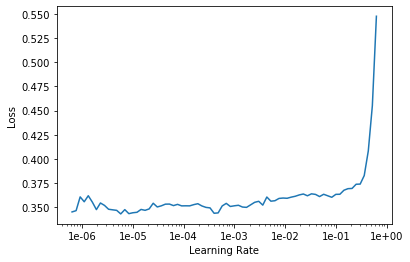

In [0]:
 # find the ideal inital learning rate for your model
ResNet.lr_find()
ResNet.recorder.plot()

In [0]:
# to pic the ideal learning rate we find the stepest part of the curve and back it up by a factor of ten.
ResNet.fit_one_cycle(10, slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,fbeta,time
0,0.349875,0.465203,0.802047,01:59
1,0.353591,0.476819,0.801468,01:59
2,0.345121,0.511685,0.800242,01:59
3,0.354354,0.386918,0.806058,02:00
4,0.348176,0.512726,0.804329,01:59
5,0.349571,0.352635,0.807787,01:59
6,0.346849,0.372166,0.803644,01:59
7,0.353978,0.512514,0.803371,01:59
8,0.350528,0.360765,0.805879,02:00
9,0.349432,0.423265,0.806799,01:59


In [0]:
# save the initial model
ResNet.save('codemash-WideResNet-16bit')

In [0]:
ResNet.export('codemash-WideResNet-16bit')

In [0]:
ResNet.export()

Object `export` not found.


## Metrics

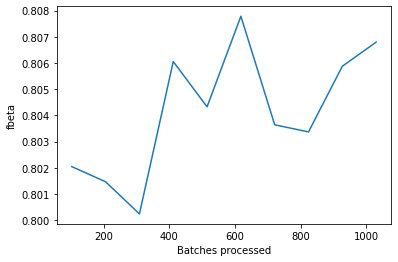

In [0]:
# we will start taking a look a the metrics
ResNet.recorder.plot_metrics()

In [0]:
#Look at your 9 worst results. By using a heatmap to see what induced the wrong classification:
interp = ClassificationInterpretation.from_learner(ResNet)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

False

99 misclassified samples over 466 samples in the validation set.


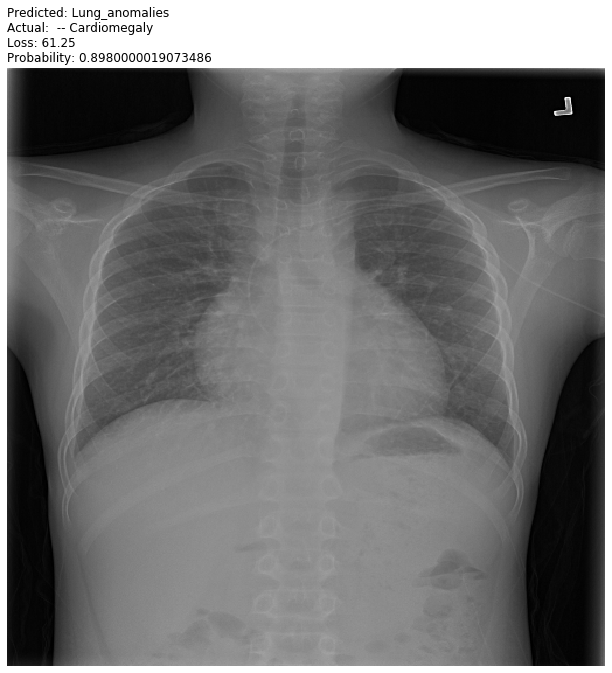

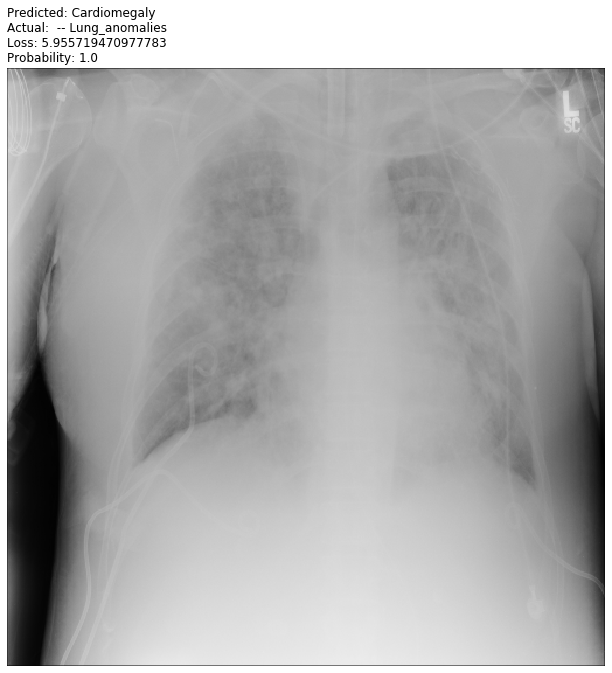

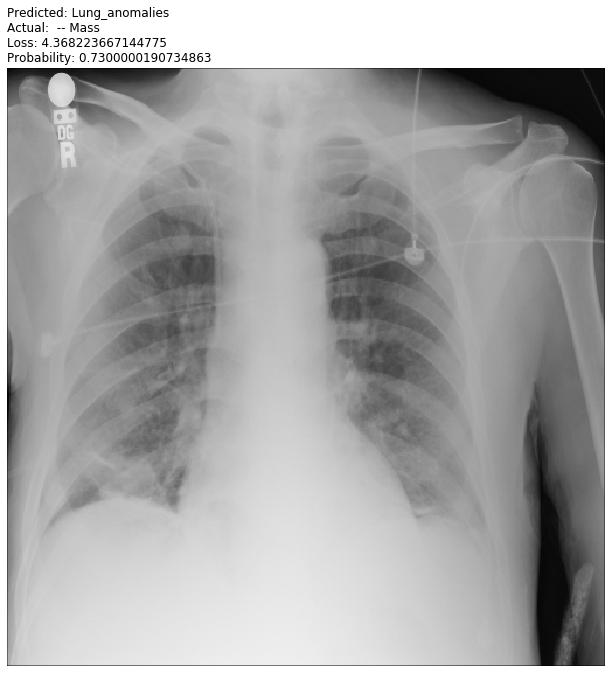

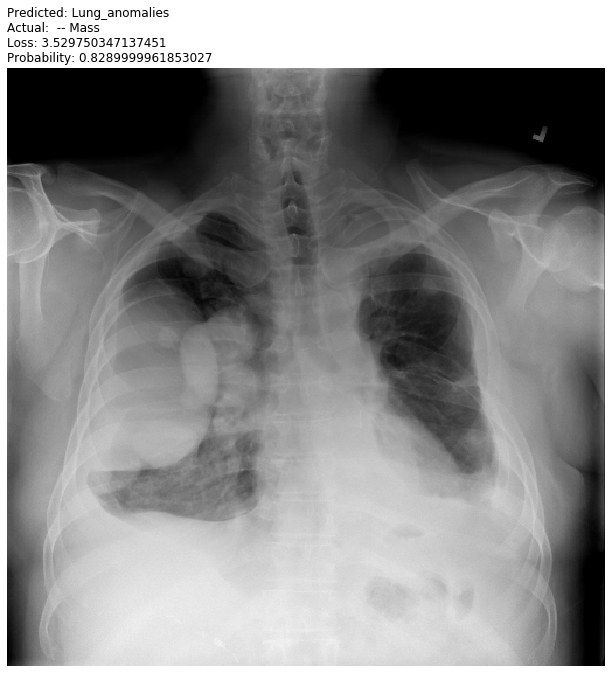

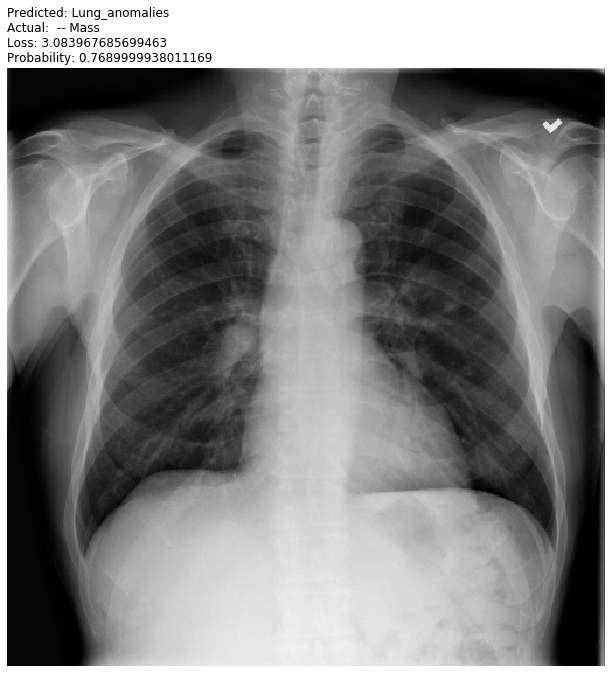

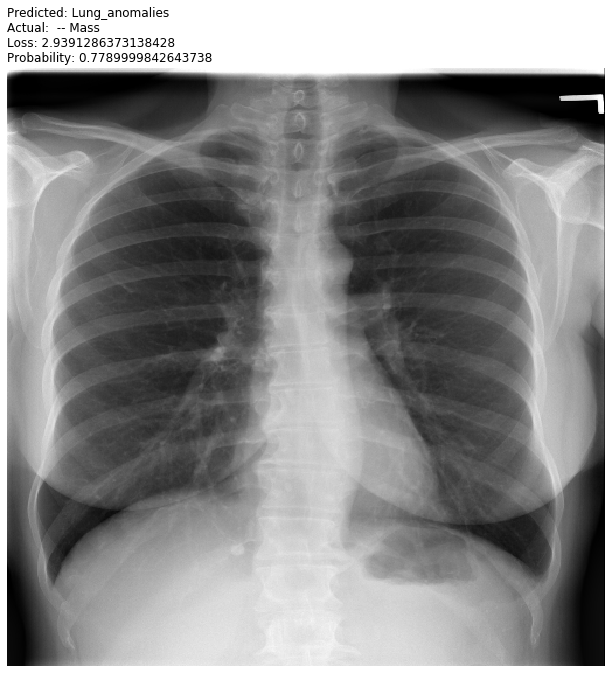

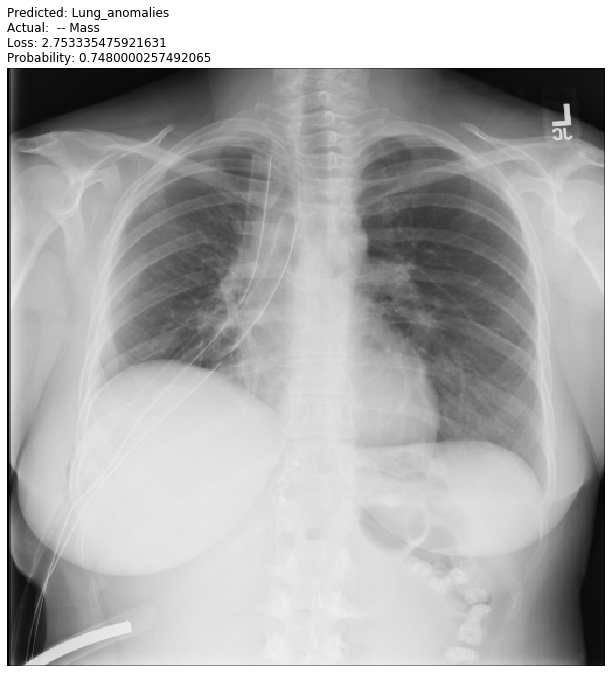

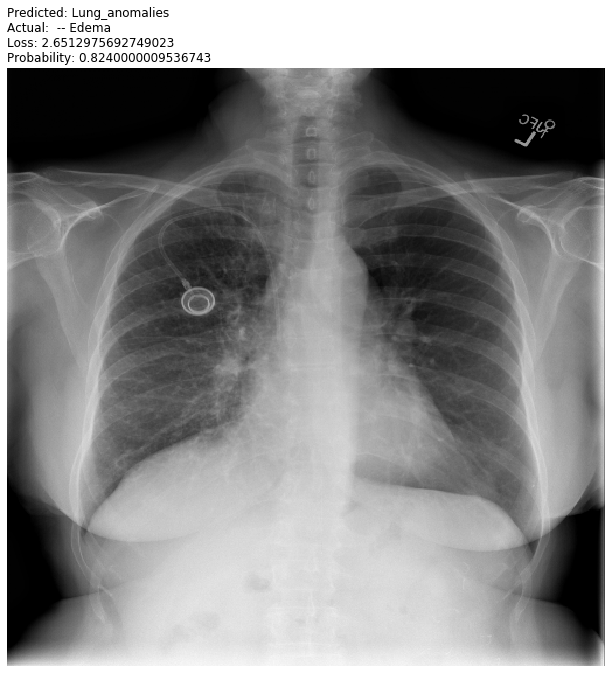

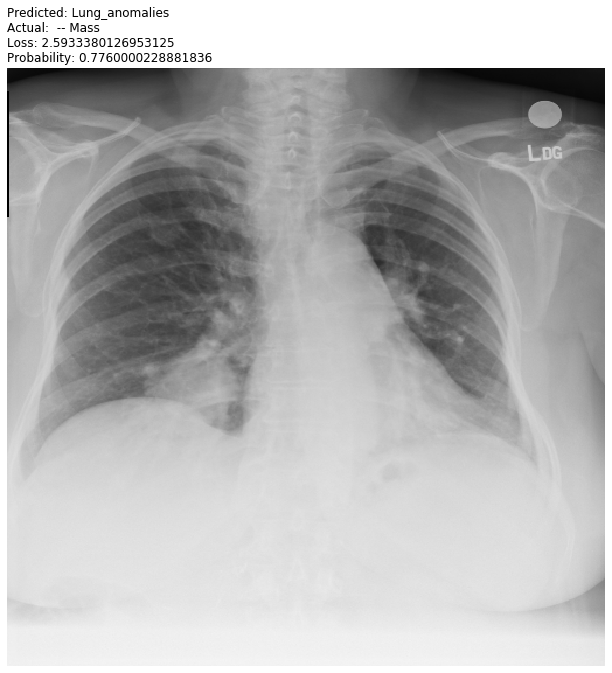

In [0]:
#plot top losses
interp.plot_multi_top_losses(9, figsize=(20,11))

In [0]:
interp.most_confused(min_val=100)

[('Cardiomegaly', 'Lung_anomalies', 1317), ('Edema', 'Lung_anomalies', 527)]

In [0]:
pred_class, pred_idx, outputs = ResNet.predict(open_image(f"{path}/00001989_001.png"))

In [0]:
[f'{round(y.item()*100):3d}% - {c}' for c,y in zip(data.classes, outputs) if y > 0.75]

[' 77% - Lung_anomalies']

In [0]:
#unfreeze previous model to continue improving the model
learn.unfreeze()

In [0]:
# EXPORT MODEL
learner.export('codemash-resnet50-16bit'')

## Ensemble Model

## Test the Finished Model

## Diagnosing and fixing problems

I added this section because of the GPU memory management issues i kept running into with working with the notebook. The basic problems comes from limited memory capicity in most cloud services. Periodically you will have to free up memory to keep the training process going. this section will help you identify memory bottle necks and fix them.

In [0]:
# use to identify gpu mem usage
!/opt/bin/nvidia-smi
!nvcc --version

#identify processes using gpu memory
print("\nKill process with 'ipykernel_launcher'\n")
!ps -aux|grep python

Sat Dec  7 22:38:36 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    31W / 250W |  16273MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# kill process with "ipkernel_launcher" to free gpu memory
!kill -9 148

# **Deploy model on webapp**

- www.render.com
- www.github.com


In [0]:
tensor = torch.randn([3,3])
tensor2 = torch.randn([3,3])

In [0]:
tensor3 = tensor*tensor2
tensor3

tensor([[-1.9968, -0.6875, -0.1467],
        [ 0.4993, -0.4538, -0.3516],
        [ 0.5357,  0.8323, -0.8544]])

In [0]:
tensor4 = tensor3+tensor2
tensor4

tensor([[-3.2483,  0.6032, -0.3266],
        [ 0.2033,  0.1400, -1.1235],
        [ 1.0273, -0.2600,  1.3276]])

In [0]:
tensor

tensor([[ 1.5955, -0.5327,  0.8160],
        [-1.6867, -0.7642,  0.4555],
        [ 1.0896, -0.7619, -0.3916]])

In [0]:
tensor.max()

tensor(1.5955)

In [0]:
tensor.argmax()

tensor(0)

In [0]:
test_tensor = torch.rand(9)
test_tensor

tensor([0.8597, 0.1868, 0.1567, 0.2273, 0.1265, 0.7206, 0.0658, 0.2787, 0.2248])

In [0]:
reshape_t = test_tensor.reshape(3,3)
reshape_t

tensor([[0.8597, 0.1868, 0.1567],
        [0.2273, 0.1265, 0.7206],
        [0.0658, 0.2787, 0.2248]])

In [0]:
test= torch.tensor([3.0,1.5], requires_grad= True)
